# **Regression**

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* outputs/datasets/cleaned/BTCAugmented.csv

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/bitcoin-forecast/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/bitcoin-forecast'

# Load Cleaned Data

Section 1 content

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/cleaned/BTCAugmented.csv", index_col='date', parse_dates=True))

print(df.shape)
df.head(5)

(2650, 18)


,open,high,low,close,Volume BTC,Volume USD,price mean,upper shadow,lower shadow,spread,trade,10 period SMA,50 period SMA,100 period SMA,12EMA,26EMA,MACD,buy/sell
date,,,,,,,,,,,,,,,,,,
2014-11-29,376.42,386.60,372.25,376.72,2746157.05,7245.19,377.9975,9.88,4.17,14.35,0.30,0.0,0.0,0.0,376.347692,376.312593,0.035100,1
2014-11-30,376.57,381.99,373.32,373.34,1145566.61,3046.33,376.3050,5.42,0.02,8.67,-3.23,0.0,0.0,0.0,375.884970,376.092401,-0.207430,0
2014-12-01,376.40,382.31,373.03,378.39,2520662.37,6660.56,377.5325,3.92,3.37,9.28,1.99,0.0,0.0,0.0,376.270360,376.262593,0.007766,1
2014-12-02,378.39,382.86,375.23,379.25,2593576.46,6832.53,378.9325,3.61,3.16,7.63,0.86,0.0,0.0,0.0,376.728766,376.483883,0.244883,1
2014-12-03,379.25,383.00,374.23,376.67,2998357.92,7908.29,378.2875,3.75,2.44,8.77,-2.58,0.0,0.0,0.0,376.719725,376.497669,0.222056,0


---

# MP Pipeline: Regressor

## Create ML pipeline

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine import transformation as vt

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ('numerical_transformation', vt.YeoJohnsonTransformer(variables=['open', 'high', 'low', 'Volume BTC', 'Volume USD', 
                         'price mean', 'upper shadow', 'lower shadow', 
                         'spread', '10 period SMA', '50 period SMA', 
                         '100 period SMA', '12EMA', '26EMA'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

Custom Class for hyperparameter optimisation

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['close'], axis=1),
    df['close'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (2120, 17) (2120,) 
* Test set: (530, 17) (530,)


## Grid Search CV - Sklearn

Use default hyperparameters to find most suitable algorithm

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Check results

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
5,GradientBoostingRegressor,0.735414,0.774869,0.819045,0.035448
2,RandomForestRegressor,0.706472,0.75856,0.805911,0.038643
3,ExtraTreesRegressor,0.706407,0.749811,0.799592,0.035636
6,XGBRegressor,0.605743,0.703395,0.782389,0.058332
1,DecisionTreeRegressor,0.539981,0.609183,0.650462,0.040267
4,AdaBoostRegressor,0.353095,0.442968,0.497109,0.048486
0,LinearRegression,0.328743,0.371711,0.394957,0.022542


## Extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search. 
Adjusted the parameter search ranges based on the best values already obtained during previous attempts

In [21]:
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor

models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html


params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [50, 100, 150],  
        'model__learning_rate': [0.05, 0.1, 0.01],  
        'model__max_depth': [3, 5],  
        'model__subsample': [0.8],  
    },
    "RandomForestRegressor": {
        'model__n_estimators': [200, 300, 500],  
        'model__max_depth': [5, 10],  
        'model__max_features': ['sqrt', 'log2'],  
        'model__min_samples_split': [5, 10], 
        'model__min_samples_leaf': [1, 2],  
    },
    "ExtraTreesRegressor": {
        'model__n_estimators': [250, 300, 400],  
        'model__max_depth': [5, 7, 10],  
        'model__max_features': [None, 'sqrt'], 
        'model__min_samples_split': [2, 5],  
        'model__min_samples_leaf': [1, 2],  
    }
}

Extensive GridSearch CV

In [22]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits



Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Check results

In [23]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__learning_rate,model__max_depth,model__n_estimators,model__subsample,model__max_features,model__min_samples_leaf,model__min_samples_split
115,ExtraTreesRegressor,0.742931,0.7866,0.831353,0.033035,NaN,10,300,NaN,None,1,2
114,ExtraTreesRegressor,0.742048,0.786266,0.831586,0.0334,NaN,10,250,NaN,None,1,2
116,ExtraTreesRegressor,0.74166,0.786266,0.830934,0.03318,NaN,10,400,NaN,None,1,2
120,ExtraTreesRegressor,0.741177,0.785923,0.83036,0.032672,NaN,10,250,NaN,None,2,2
121,ExtraTreesRegressor,0.740672,0.785763,0.830369,0.03282,NaN,10,300,NaN,None,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
88,ExtraTreesRegressor,0.602224,0.634395,0.663147,0.02175,NaN,5,300,NaN,sqrt,2,5
86,ExtraTreesRegressor,0.596926,0.631241,0.65988,0.022743,NaN,5,400,NaN,sqrt,2,2
89,ExtraTreesRegressor,0.598232,0.629538,0.658718,0.021293,NaN,5,400,NaN,sqrt,2,5
15,GradientBoostingRegressor,0.460537,0.494979,0.517491,0.021714,0.01,5,50,0.8,NaN,NaN,NaN


Check the best model

In [24]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'ExtraTreesRegressor'

Parameters for best model

In [25]:
grid_search_pipelines[best_model].best_params_

{'model__max_depth': 10,
 'model__max_features': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 300}

Define the best regressor, based on search

In [26]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('numerical_transformation',
                 YeoJohnsonTransformer(variables=['open', 'high', 'low',
                                                  'Volume BTC', 'Volume USD',
                                                  'price mean', 'upper shadow',
                                                  'lower shadow', 'spread',
                                                  '10 period SMA',
                                                  '50 period SMA',
                                                  '100 period SMA', '12EMA',
                                                  '26EMA'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=10, max_features=None,
                                     n_estimators=300, random_state=0))])

## Assess feature importance

* These are the 2 most important features in descending order. The model was trained on them: 
['MACD', 'Volume USD']


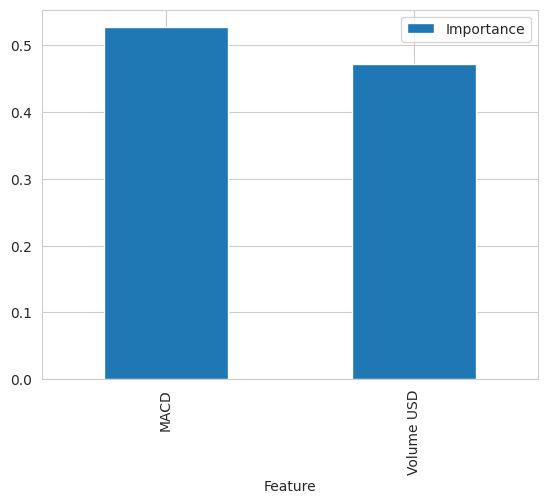

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate on Train and Test Sets

In [28]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.867
Mean Absolute Error: 2831.999
Mean Squared Error: 34782925.075
Root Mean Squared Error: 5897.705


* Test Set
R2 Score: 0.794
Mean Absolute Error: 3886.715
Mean Squared Error: 57371886.582
Root Mean Squared Error: 7574.423




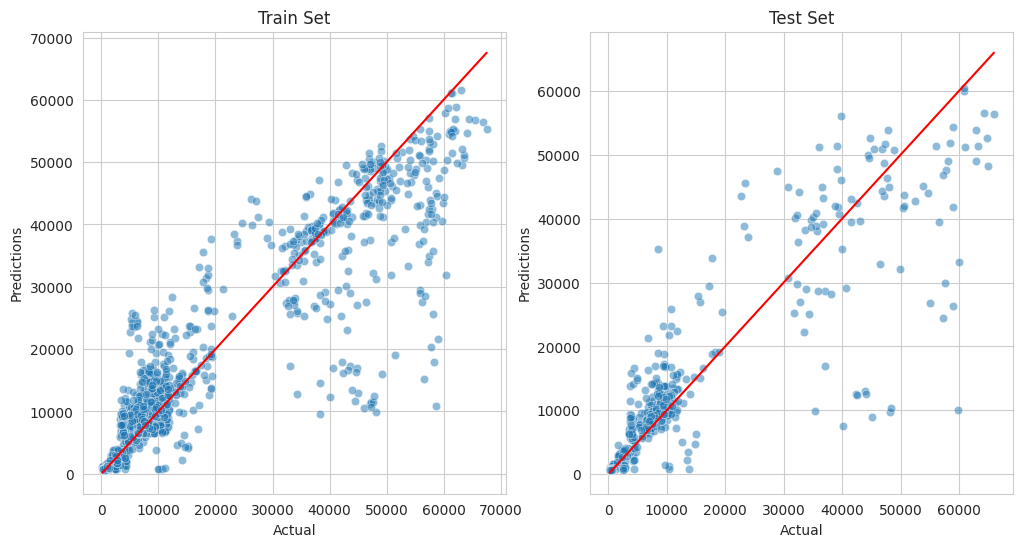

In [29]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
